# Librería FB Prophet aplicada a datos de energía descargados de E-Distribución. 
Para el análisis de la tendencias encaminado a obtener previsiones de consumo, vamos a hacer uso de los datos proporcionados en el area de clientes de E-Distribución Redes Digitales:
https://zonaprivada.edistribucion.com/areaprivada/s/login/?language=es

Para tener acceso a los datos de esta web, es necesario registrarse como consumidor particular, proporcionando el NIF del titular del contrato.
Una vez hecho esto, en el primer acceso se deberá establecer la contraseña.

Una vez dentro del portal, en el apartado `Gestión del Suministro` --> `Mi consumo` --> `Consulta de curvas de consumo`. En la parte derecha seleccionar `Servicios` --> `Descarga masiva de curvas`. De esta forma podremos descargar datos desde el inicio del contrato.

Se selecciona el CUPS (Código Universal de Punto de Suministro) asociado a la vivienda que se pretende analizar, y se establece el rango máximo que permitan los selectores de fechas. Marcaremos la casilla `Datos horarios`.Es posible realizar la descarga también mediante datos cuarto-horarios, lo cual podría permitir mayor precisión pero una mayor dificultad en el tratamiento de los datos, por lo que en principio nos centramos en los datos horarios. Botón `Solicitar Descarga` y deberemos esperar unos momentos para que los datos estén disponibles. Podemos pulsar F5 para actualizar el navegador y fijarnos en el símbolo de la campana que nos avisará cuando los datos estén disponibles.
La descarga es un archivo comprimido que contiene dos ficheros CSV nombrados como sigue: 
- {CUPS}_{FechaInicio}_{FechaFin}_Horario.csv
  
| CUPS | Fecha | Hora | AE_kWh | AS_KWh | AE_AUTOCONS_kWh | REAL/ESTIMADO |
|------|-------|------|--------|--------|-----------------|---------------|

- {CUPS}_{FechaInicio}_{FechaFin}_Horario_CCH_CONS.csv 

| CUPS | Fecha | Hora | AE_kWh | REAL/ESTIMADO |
|------|-------|------|--------|---------------|

Los datos se descargan en CSV en el formato `Facturaluz`, que tiene la siguiente interpretación:
- AE_kWh: Es la energía activa consumida en kilovatios hora (kWh)
- AS_kWh: Energía activa suministrada o vertida a la red en kilovatios hora (kWh)
- AE_AUTOCONS_kWh: Energía autoconsumida en kilovatios hora (kWh). Muestra la energía que ha sido generada por una instalación de autoconsumo y utilizada directamente en el punto de suministro, sin ser vertida a la red.

Por tanto, cualquiera de los dos ficheros nos sirve para el análisis de la energía activa consumida por una vivienda simplemente observando los datos de la columna `AE_kWh`
Los datos ya representan el consumo del periodo sin tener que hacer diferencias con el periodo anterior.

Estos ficheros tienen una particularidad en el tratamiento de las horas, ya que las horas van de 1 a 24 indicando el final del periodo de registro. En nuestro tratamiento necesitamos que estos números vayan de 0 a 23 para que indiquen el inicio del periodo en el que se producirá el consumo en un formato normalizado de hora como puede ser el ISO8601
Además, en los cambios de hora como los que suceden a final de octubre aparece una hora 25 que debe ser convertida a 24.

Por tanto renombramos uno de estos ficheros a `edistribucion.csv`

In [455]:

import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
# importar sns
import seaborn as sns


# Definir funciones para evaluar los resultados. Métricas de Error

In [456]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el error porcentual absoluto medio MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_error(y_true, y_pred):
    """Calcula el error cuadrático medio MSE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

# Cargar datos desde fichero CSV

In [457]:
# Establecer el nombre del archivo CSV
#csv_file = 'data/edistribucionMabuse.csv'
csv_file = 'data/edistribucionErmesinda.csv'

# Especificar las columnas a cargar
columnas_deseadas = ['Fecha', 'Hora', 'AE_kWh']

# Carga el CSV solo con las columnas especificadas, separador de columnas ';' y separador decimal ','
data = pd.read_csv(csv_file, usecols=columnas_deseadas, sep=';', decimal=',')

# Convertir la columna 'Fecha' al formato datetime especificando el formato 'dd/mm/yyyy'
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')

# horas van de 1 a 24 en lugar de 0 a 23
data['Hora'] = data['Hora'] - 1

# Todavía puede quedar algún valor 24 por los cambios de hora de final de octubre
data['Hora'] = data['Hora'].replace(24, 23)

# Borrar valores NaN
data = data.dropna()

data = data.groupby(['Fecha', 'Hora']).sum().reset_index()

# Convertir la columna 'Hora' a una cadena y formatearla para que tenga dos dígitos
data['Hora'] = data['Hora'].apply(lambda x: f"{int(x):02d}:00:00")

# Combinar las columnas 'Fecha' y 'Hora' en una nueva columna de tipo datetime
data['FechaHora'] = pd.to_datetime(data['Fecha'].astype(str) + ' ' + data['Hora'])

# Establece la nueva columna combinada como el índice del DataFrame
data.set_index('FechaHora', inplace=True)

# Elimina las columnas originales 'Fecha' y 'Hora' si ya no son necesarias
data.drop(columns=['Fecha', 'Hora'], inplace=True)

# Asegurarse de que las fechas están ordenadas correctamente
data.sort_index(inplace=True)

In [458]:
# Muestra las primeras y últimas filas del DataFrame
print("Primeras filas del DataFrame:")
data.head()

Primeras filas del DataFrame:


,AE_kWh
FechaHora,
2022-10-01 00:00:00,0.172
2022-10-01 01:00:00,0.156
2022-10-01 02:00:00,0.242
2022-10-01 03:00:00,0.222
2022-10-01 04:00:00,0.156


In [459]:
print("Últimas filas del DataFrame:")
data.tail()

Últimas filas del DataFrame:


,AE_kWh
FechaHora,
2024-10-20 19:00:00,0.335
2024-10-20 20:00:00,0.331
2024-10-20 21:00:00,0.309
2024-10-20 22:00:00,0.337
2024-10-20 23:00:00,0.250


In [460]:
print("Resumen del DataFrame:")
data.describe()

Resumen del DataFrame:


,AE_kWh
count,18022.000000
mean,0.291303
std,0.220595
min,0.086000
25%,0.170000
50%,0.227000
75%,0.319000
max,2.519000


In [461]:
# Borrado bloque para corrección de datos solares presente en NB04. 
# Simplemente copiar los datos originales de data en total_data
# Renombrar la columna de data AE_kWh a total_kWh
data.rename(columns={'AE_kWh': 'total_kWh'}, inplace=True)
total_data = data.copy()

# Almacenar la primera fecha de los datos
first_data = total_data.index[0] 
print(f"Primera fecha de los datos: {first_data.strftime('%d/%m/%Y %H:%M:%S')}")
last_data = total_data.index[-1]
print(f"Última fecha de los datos: {last_data.strftime('%d/%m/%Y %H:%M:%S')}")


Primera fecha de los datos: 01/10/2022 00:00:00
Última fecha de los datos: 20/10/2024 23:00:00


# Definir rango de fechas de entrenamiento y de prueba
En el siguiente bloque de código vamos a definir que proporción de los datos queremos utilizar mediante los parametros `start_date` y `end_date` que se usarán para recortar el dataframe `data`.

Se establece `split_date` 7 días antes del `end_date`. 

El modelo se entrena con los datos entre `start_date` y  `split_date`.

Las predicciones se realizan para fechas entre `split_date` y `end_date` y se comparan con los valores reales.

In [462]:
all_data=True
meses = 8   # seleccionar meses=0 para indicar fechas exactas
end_date = pd.to_datetime('01/06/2023', format='%d/%m/%Y')
if all_data:
    start_date = first_data
    end_date = last_data
else:
    if meses > 0:
        # end_date = last_data
        start_date = end_date - pd.DateOffset(months=meses)
    else:
        start_date = pd.to_datetime('01/12/2022', format='%d/%m/%Y')
        end_date = pd.to_datetime('01/02/2023', format='%d/%m/%Y')



split_date = end_date - pd.DateOffset(days=4)

# Eliminar los datos anteriores a la fecha de inicio
total_data = total_data[total_data.index >= start_date]
# Eliminar los datos posteriores a la fecha de fin
total_data = total_data[total_data.index < end_date]

# Mostrar las fechas con las que se va a trabajar
print(f"Fecha de inicio: {start_date.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Fecha de fin: {end_date.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Fecha de corte: {split_date.strftime('%d/%m/%Y %H:%M:%S')}")


Fecha de inicio: 01/10/2022 00:00:00
Fecha de fin: 20/10/2024 23:00:00
Fecha de corte: 16/10/2024 23:00:00


# Datos brutos de la energía consumida.

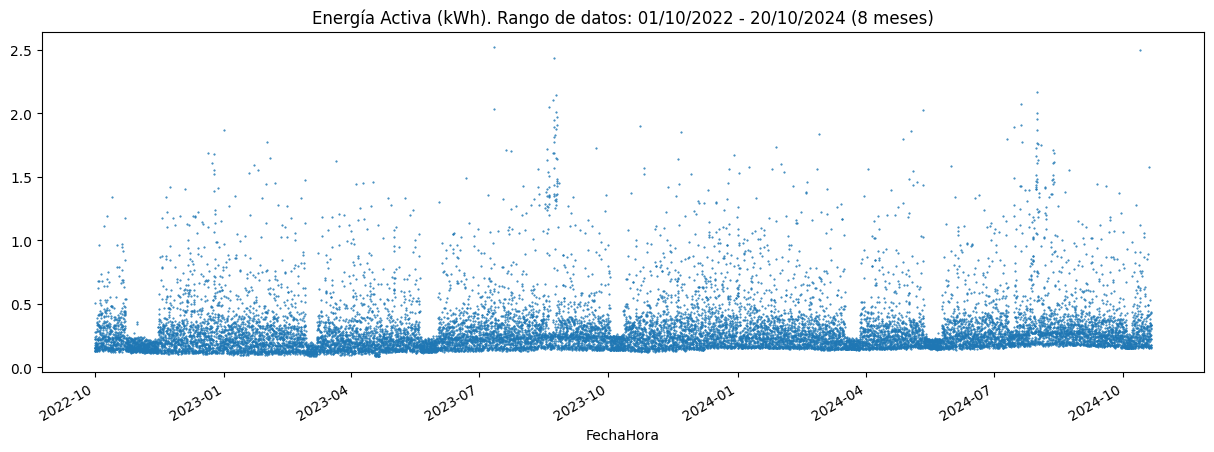

In [463]:
# Crear una figura y un eje
color_pal = sns.color_palette()
ax = total_data['total_kWh'].plot(style='.', 
                        figsize=(15, 5), 
                        ms=1,
                        color=color_pal[0], 
                        title=f'Energía Activa (kWh). Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')

plt.show()

# Valores característicos de la energía consumida. Datos agrupados por día.

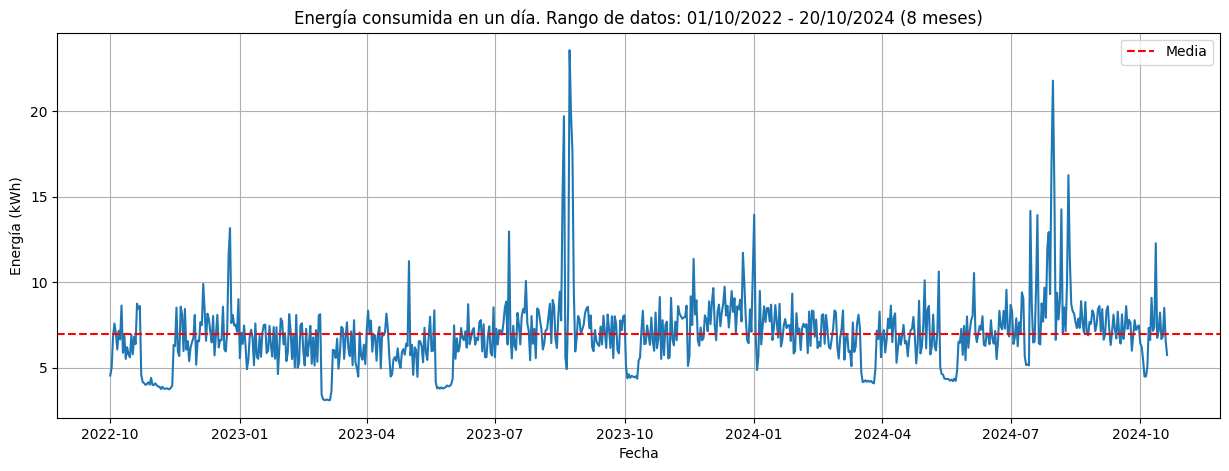

Energía media consumida en un solo día: 6.99 kWh
Energía máxima consumida en un solo día: 23.57 kWh
Energía mínima consumida en un solo día: 3.09 kWh
Varianza de la energía consumida en un solo día: 4.34 kWh^2
Desviación estándar de la energía consumida en un solo día: 2.08 kWh


In [464]:
# Caracterizar los datos de energía consumida en el rango de fechas seleccionado para un solo día. 
daily_energy = total_data.groupby(total_data.index.date).sum()
mean_value = daily_energy['total_kWh'].mean()
max_value = daily_energy['total_kWh'].max()
min_value = daily_energy['total_kWh'].min()
variance_value = daily_energy['total_kWh'].var()
std_deviation_value = daily_energy['total_kWh'].std()

# Representar la energía consumida en función de la fecha y mostrar la media
plt.figure(figsize=(15, 5))
plt.plot(daily_energy.index, daily_energy['total_kWh'])
plt.axhline(mean_value, color='r', linestyle='--', label='Media')
plt.title(f'Energía consumida en un día. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.xlabel('Fecha')
plt.ylabel('Energía (kWh)')
plt.legend()
plt.grid()
plt.show()
# Mostrar valores de energía consumida en un solo día
print(f"Energía media consumida en un solo día: {mean_value:.2f} kWh")
print(f"Energía máxima consumida en un solo día: {max_value:.2f} kWh")
print(f"Energía mínima consumida en un solo día: {min_value:.2f} kWh")
print(f"Varianza de la energía consumida en un solo día: {variance_value:.2f} kWh^2")
print(f"Desviación estándar de la energía consumida en un solo día: {std_deviation_value:.2f} kWh")



In [465]:
total_data.describe()

,total_kWh
count,18021.000000
mean,0.291306
std,0.220600
min,0.086000
25%,0.170000
50%,0.227000
75%,0.319000
max,2.519000


La descripción de los datos caracteriza el valor del consumo por hora para el rango completo de datos

# Análisis visual de los datos. Características de estacionalidad

In [466]:
# Time series features
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df=df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek #Monday=0, Sunday=6
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int) # df['date'].dt.weekofyear ya no está disponible en pandas 1.1.0
    # df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(np.int8)
    df['is_weekend'] = df['dayofweek'].isin([5, 6])
    # df['dayofweek'] = df['dayofweek'].astype(cat_type)
    # Patron estacional
    # Convertir la fecha a un número entre 0 y 1300 y fijar el 20 de marzo como el día 0 (día 0320)
    # Las fechas anteriores al 20 de marzo serán negativas y las fechas posteriores serán positivas
    # Se toma el módulo 1300 para que el patrón estacional se repita cada 1300 días
    df['date_offset'] = (df.date.dt.month*100+df.date.dt.day-320)%1300 # for seasonal pattern
    df['season'] = pd.cut(df['date_offset'], [0,300,602,900,1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear','is_weekend', 'season']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = create_features(total_data, label='total_kWh')
# Concatenar las características y el objetivo en un solo DataFrame
features_and_target = pd.concat([X, y], axis=1) # axis=1 para concatenar por columnas (se unirán horizontalmente)
features_and_target.head()


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,season,total_kWh
FechaHora,,,,,,,,,,,
2022-10-01 00:00:00,0,5,4,10,2022,274,1,39,True,Fall,0.172
2022-10-01 01:00:00,1,5,4,10,2022,274,1,39,True,Fall,0.156
2022-10-01 02:00:00,2,5,4,10,2022,274,1,39,True,Fall,0.242
2022-10-01 03:00:00,3,5,4,10,2022,274,1,39,True,Fall,0.222
2022-10-01 04:00:00,4,5,4,10,2022,274,1,39,True,Fall,0.156


In [467]:
features_and_target.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,season,total_kWh
FechaHora,,,,,,,,,,,
2024-10-20 18:00:00,18,6,4,10,2024,294,20,42,True,Fall,0.253
2024-10-20 19:00:00,19,6,4,10,2024,294,20,42,True,Fall,0.335
2024-10-20 20:00:00,20,6,4,10,2024,294,20,42,True,Fall,0.331
2024-10-20 21:00:00,21,6,4,10,2024,294,20,42,True,Fall,0.309
2024-10-20 22:00:00,22,6,4,10,2024,294,20,42,True,Fall,0.337


## Representación gráfica de los datos de partida
Con el objetivo de visualizar y detectar a golpe de vista posibles tendencias vamos a representar los datos en un gráfico de caja de Seaborn.

sns.boxplot:

Esta función de Seaborn se utiliza para crear un gráfico de caja. Un gráfico de caja muestra la distribución de datos basada en un resumen de cinco números: mínimo, primer cuartil (Q1), mediana (Q2), tercer cuartil (Q3) y máximo.


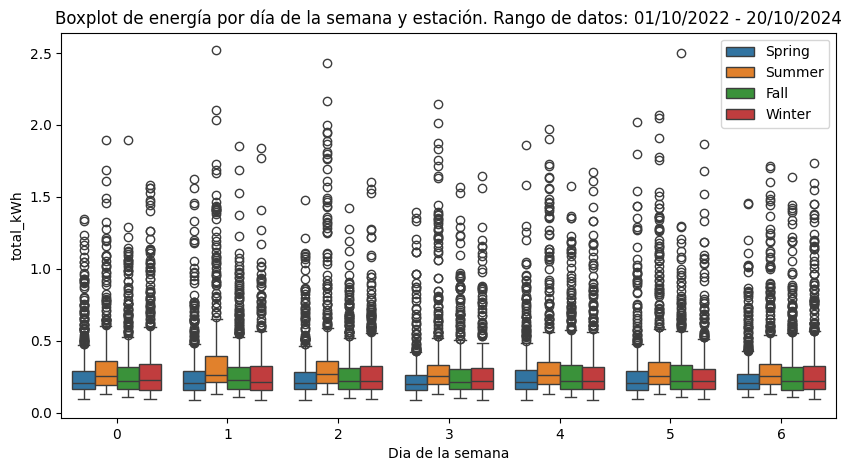

In [468]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(), # Asegurar solo filas completas
             x='dayofweek', 
             y='total_kWh', 
             hue='season', # Dimensión adicional, para cada x
             ax=ax,
             linewidth=1)
ax.set_title(f'Boxplot de energía por día de la semana y estación. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")}')
ax.set_xlabel('Dia de la semana')
ax.set_ylabel('total_kWh')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Se procesan un conjunto de más de 18000 datos con valores de consumo de energía por hora, y se intenta caracterizar si existe algún patrón que revele alguna tendencia por día de la semana o por estación del año. Los círculos por encima de Q3 indican momentos en que el consumo ha quedado completamente fuera de la tendencia. 0 corresponde a lunes. Se observa un patron claro de mayor consumo en verano asociado al uso del aire acondicionado.
Más allá de esto no, a simple vista no hay mucho más que se pueda observar. Habrá que ver que es capaz de hacer Prophet cuando reciba los datos brutos.

# Dividir el conjunto de datos en dos grupos
- Train: deberá incluir la mayor parte de los datos y serán los utilizados para el entrenamiento del modelo Prophet
- Test Split: Una pequeña porción de los datos al final de la serie que será utilizada para verificar la exactitud de la predicción.


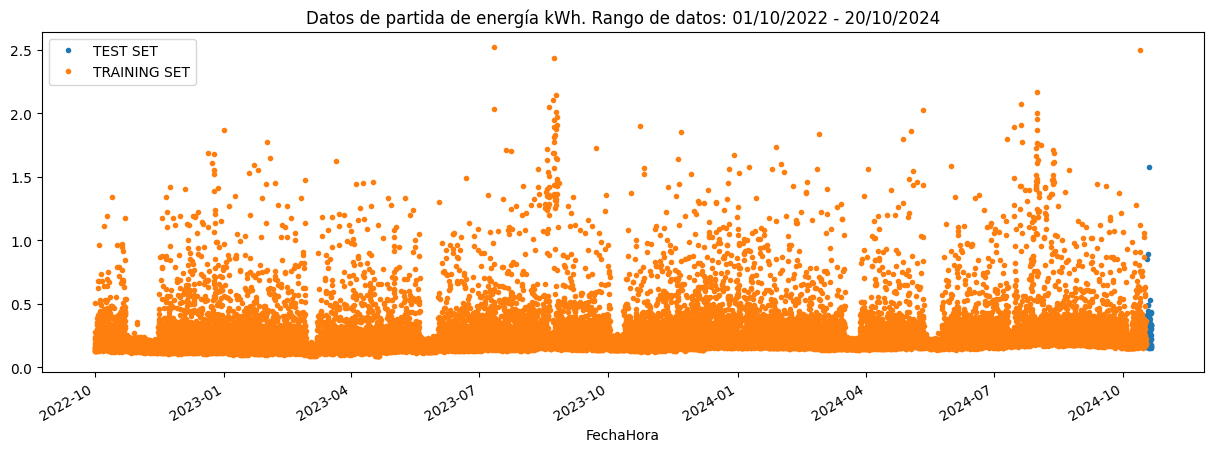

In [469]:
# Generar dos dataframes separados para entrenamiento y prueba
train = total_data.loc[total_data.index < split_date].copy()
test = total_data.loc[total_data.index >= split_date].copy()

# Plotear train y test para visualizar la separación
test \
    .rename(columns={'total_kWh': 'TEST SET'})\
    .join(train.rename(columns={'total_kWh': 'TRAINING SET'}), 
          how='outer')\
    .plot(figsize=(15,5), title=f'Datos de partida de energía kWh. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")}', style='.')
plt.show()


La zona naranja son los datos con los que se va a entrenar a Prophet. La zona azul se usará para comparar las predicciones hechas por Prophet con los datos reales que tuvieron lugar en ese momento.

# Modelo Simple de Prophet
Los modelos de Prophet esperan recibir los dataset de un modo específico. Por tanto tendremos que renombrar las columnas del dataset `train` para que coincidan con los esperado por Prophet:
    - Columna de tipo datetime llamada: `ds`
    - Columna objetivo llamada: `y`

In [470]:
# Format data for prophet model using ds and y  
train_prophet = train.reset_index().rename(columns={'FechaHora':'ds', 'total_kWh':'y'})
test_prophet = test.reset_index().rename(columns={'FechaHora':'ds', 'total_kWh':'y'})
train_prophet.head()

,ds,y
0,2022-10-01 00:00:00,0.172
1,2022-10-01 01:00:00,0.156
2,2022-10-01 02:00:00,0.242
3,2022-10-01 03:00:00,0.222
4,2022-10-01 04:00:00,0.156


Definir el modelo y ajustar los datos

In [471]:
train_prophet.tail()

,ds,y
17920,2024-10-16 18:00:00,0.225
17921,2024-10-16 19:00:00,0.189
17922,2024-10-16 20:00:00,0.364
17923,2024-10-16 21:00:00,0.190
17924,2024-10-16 22:00:00,0.182


In [472]:
%%time
model = Prophet()
# Aunque por defecto buscará patrones dentro de cada día, se puede especificar un orden mayor para la estacionalidad deseada.
# fourier_order es el número de componentes de Fourier a usar, cuanto mayor sea el número, más flexible será el modelo
# Agregar estacionalidad horaria con mayor orden. Period se indica en la misma unidad de la columna ds
# Finalmente se deshabilita ya que no mejora en exceso y se aumenta el tiempo de procesamiento.
# model.add_seasonality(name='horaria', period=1, fourier_order=6)
model.fit(train_prophet)

17:22:37 - cmdstanpy - INFO - Chain [1] start processing
17:22:40 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 2.3 s
Wall time: 5.22 s


In [473]:
test_prophet.head()

,ds,y
0,2024-10-16 23:00:00,0.307
1,2024-10-17 00:00:00,0.174
2,2024-10-17 01:00:00,0.168
3,2024-10-17 02:00:00,0.247
4,2024-10-17 03:00:00,0.178


Utilizar el modelo para generar una predicción

In [474]:
# Predict on test set with model
test_forecast = model.predict(test_prophet)

test_prophet solo se pasa para establecer las fechas en las que solicitamos la predicción no para que use los valores de y
Ahora test_forecast tendrá la predicción para las fechas definidas en test_prophet.

In [475]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-10-16 23:00:00,0.310221,0.028429,0.549802,0.310221,0.310221,-0.033671,-0.033671,-0.033671,-0.013473,...,-0.004366,-0.004366,-0.004366,-0.015832,-0.015832,-0.015832,0.0,0.0,0.0,0.276550
1,2024-10-17 00:00:00,0.310221,-0.064802,0.447413,0.310221,0.310221,-0.101649,-0.101649,-0.101649,-0.080423,...,-0.005335,-0.005335,-0.005335,-0.015890,-0.015890,-0.015890,0.0,0.0,0.0,0.208573
2,2024-10-17 01:00:00,0.310222,-0.068689,0.440457,0.310222,0.310222,-0.136857,-0.136857,-0.136857,-0.114622,...,-0.006286,-0.006286,-0.006286,-0.015949,-0.015949,-0.015949,0.0,0.0,0.0,0.173366
3,2024-10-17 02:00:00,0.310223,-0.071303,0.442267,0.310223,0.310223,-0.135187,-0.135187,-0.135187,-0.111970,...,-0.007209,-0.007209,-0.007209,-0.016008,-0.016008,-0.016008,0.0,0.0,0.0,0.175036
4,2024-10-17 03:00:00,0.310224,-0.062702,0.446366,0.310224,0.310224,-0.123667,-0.123667,-0.123667,-0.099504,...,-0.008095,-0.008095,-0.008095,-0.016068,-0.016068,-0.016068,0.0,0.0,0.0,0.186557


El dataframe `test_forecast` contiene los datos de la previsión. Está compuesto de muchas columnas, pero las más relevantes en general serán: 
- `yhat`: valor de la predicción (y gorro o como se suele escribir ŷ)
- `yhat_lower`: límite inferior del intervalo de confianza al 80% (valor mínimo que se predice con el 80% de probabilidad)
- `yhat_upper`: límite superior del intervalo de confianza al 80% (valor máximo que se predice con el 80% de probabilidad)

In [476]:
train_prophet[['ds', 'y']].tail()

,ds,y
17920,2024-10-16 18:00:00,0.225
17921,2024-10-16 19:00:00,0.189
17922,2024-10-16 20:00:00,0.364
17923,2024-10-16 21:00:00,0.190
17924,2024-10-16 22:00:00,0.182


In [477]:
test_forecast[['ds','yhat']].head()

,ds,yhat
0,2024-10-16 23:00:00,0.276550
1,2024-10-17 00:00:00,0.208573
2,2024-10-17 01:00:00,0.173366
3,2024-10-17 02:00:00,0.175036
4,2024-10-17 03:00:00,0.186557


In [478]:
# Concatenar las predicciones con los datos de prueba para visualizar algunos datos
result=pd.concat([test_prophet.set_index('ds')[['y']], test_forecast.set_index('ds')[['yhat']]], axis=1)        
result.head(12)

,y,yhat
ds,,
2024-10-16 23:00:00,0.307,0.276550
2024-10-17 00:00:00,0.174,0.208573
2024-10-17 01:00:00,0.168,0.173366
2024-10-17 02:00:00,0.247,0.175036
2024-10-17 03:00:00,0.178,0.186557
2024-10-17 04:00:00,0.163,0.180138
2024-10-17 05:00:00,0.223,0.156487
2024-10-17 06:00:00,0.192,0.144162
2024-10-17 07:00:00,0.159,0.170411


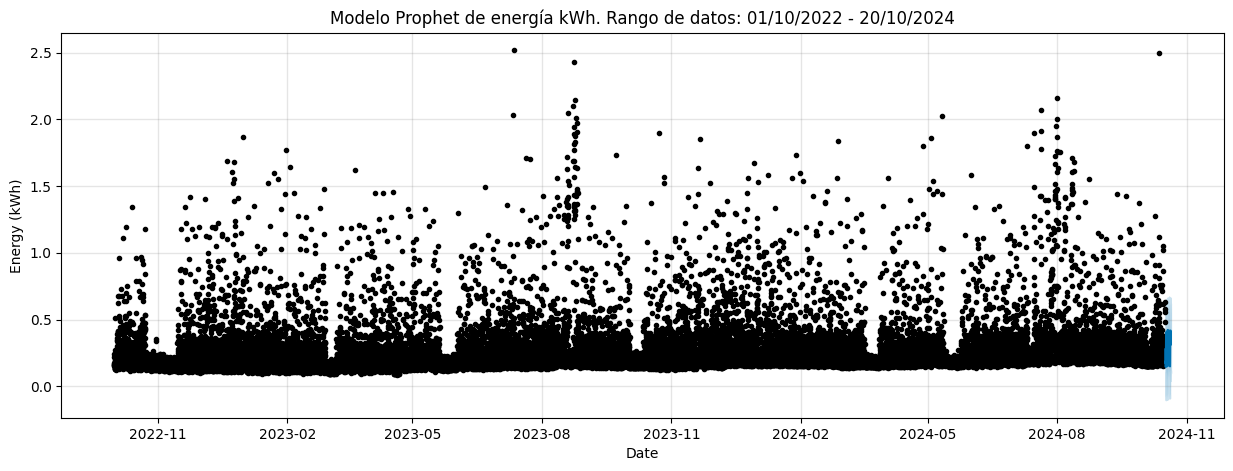

In [479]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(test_forecast, xlabel='Date', ylabel='Energy (kWh)', ax=ax)   
ax.set_title(f'Modelo Prophet de energía kWh. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")}')
plt.show()

Los puntos negros son los datos con los que se ha entrenado el modelo, los puntos azul oscuro son las predicciones. Las puntos azul claro representan los intervalos de confianza dentro de los que se espera que se encuentre el valor real con un cierto nivel de confianza (80%)

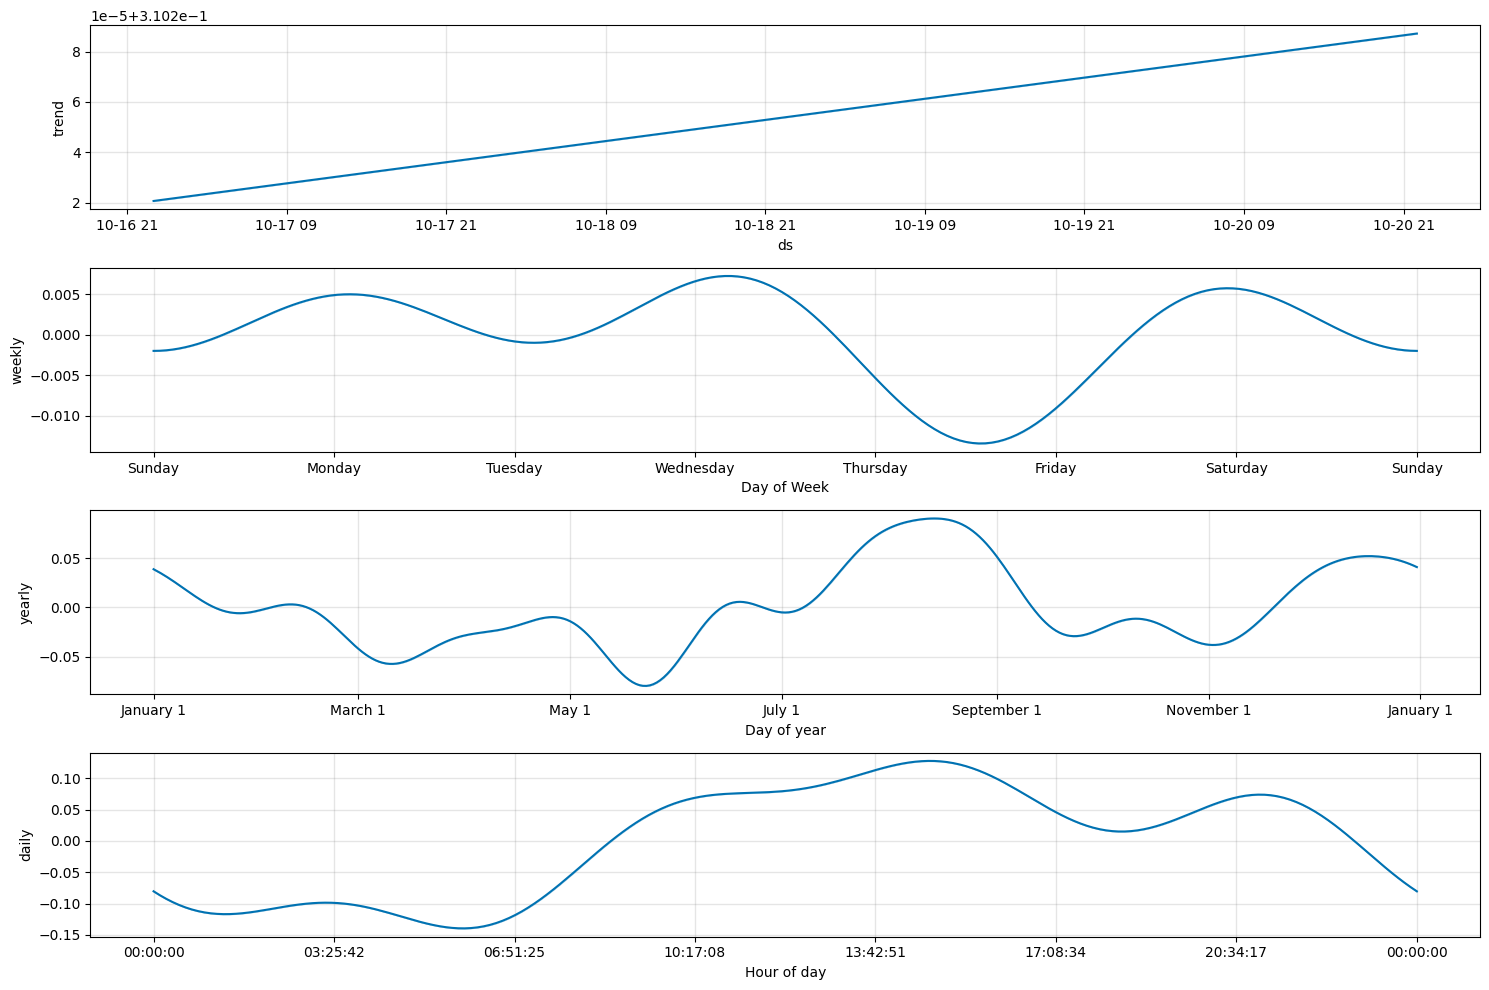

In [480]:
fig = model.plot_components(test_forecast, figsize=(15, 10))
plt.show()

La gráfica representa los términos aditivos sobre la tendencia con los que se arrojarán los resultados de la predicción.
Lo que se refleja en las figuras es:
    1. Tendencia con sus intervalos de confianza. Prácticamente no se aprecia el intervalo de confianza ya que se solapa con la linea de tendencia, indicando un valor muy ajustado para el nivel de confianza del 80%. Es ligeramente visible en el tramo final (en el futuro lejano mayor incertidumbre).
    2. Términos aditivos que reflejan la estacionalidad respecto a la tendencia: semanal, anual, diaria y horaria.

La suma de todos los términos ofrecerá el valor para un momento concreto. 

## Comparar la previsión con los datos reales

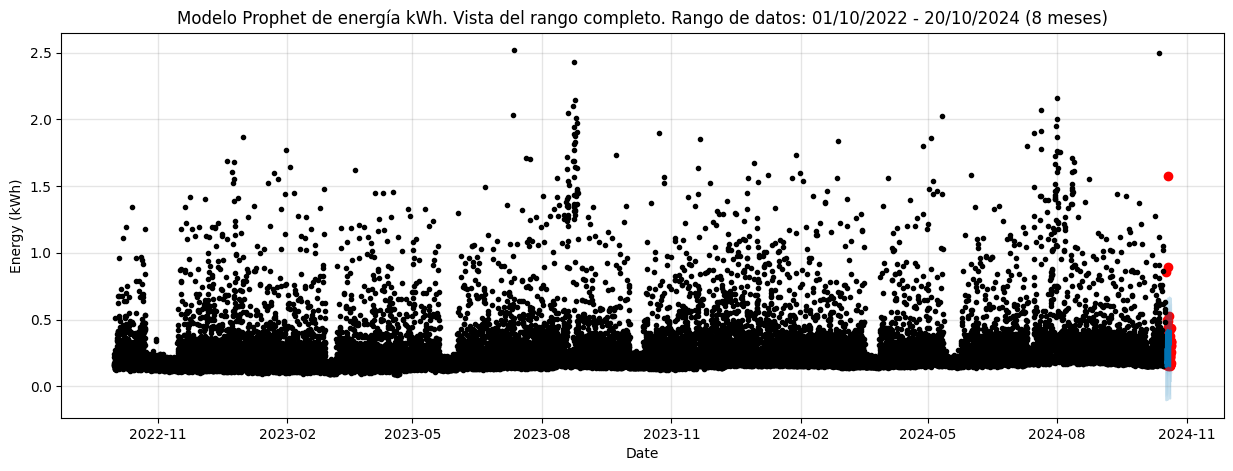

In [481]:
# Mostrar la previsión junto con los datos reales completos
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model.plot(test_forecast, ax=ax, xlabel='Date', ylabel='Energy (kWh)')
ax.set_title(f'Modelo Prophet de energía kWh. Vista del rango completo. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.show()


En rojo se muestran los valores reales del dataframe `test` que contiene los valores posteriores al entrenamiento del modelo
Estos datos se superponen sobre la información que ya habíamos visto antes donde en negro se muestran los datos con los que ha sido entrenado y en azul las predicciones.

## Hacer zoom en la zona de test

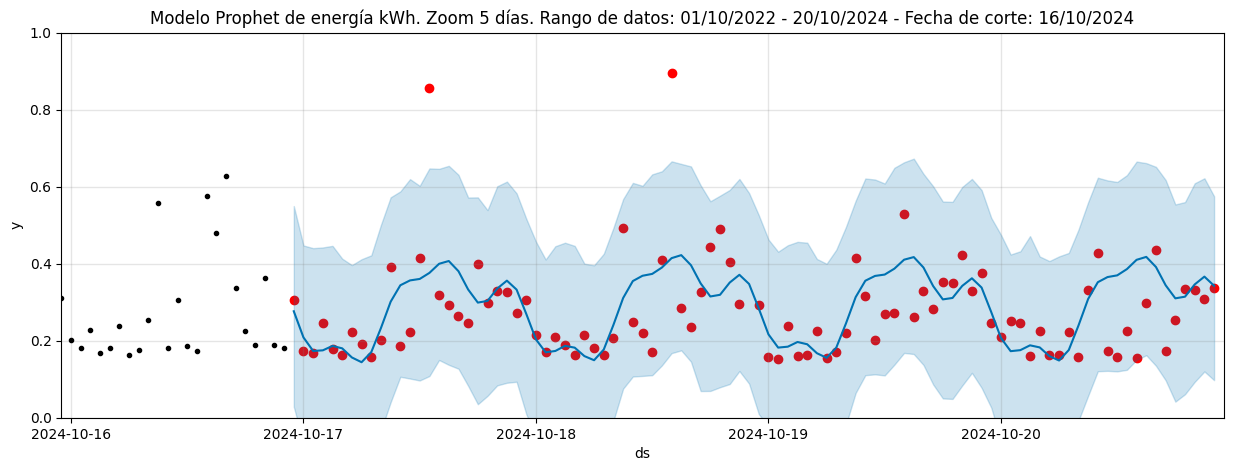

In [482]:
# Mostrar la previsión junto con los datos reales solo en fechas cercanas de la fecha de división
range_start = pd.to_datetime(split_date)-pd.DateOffset(days=1)
range_end = range_start + pd.DateOffset(days=5)

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model.plot(test_forecast, ax=ax)
ax.set_title(f'Modelo Prophet de energía kWh. Zoom 5 días. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} - Fecha de corte: {split_date.strftime("%d/%m/%Y")}')
ax.set_xbound(lower=range_start, upper=range_end)
ax.set_ybound(lower=0, upper=1)

plt.show()

## Inspeccionar los datos por horas del primer día de la predicción

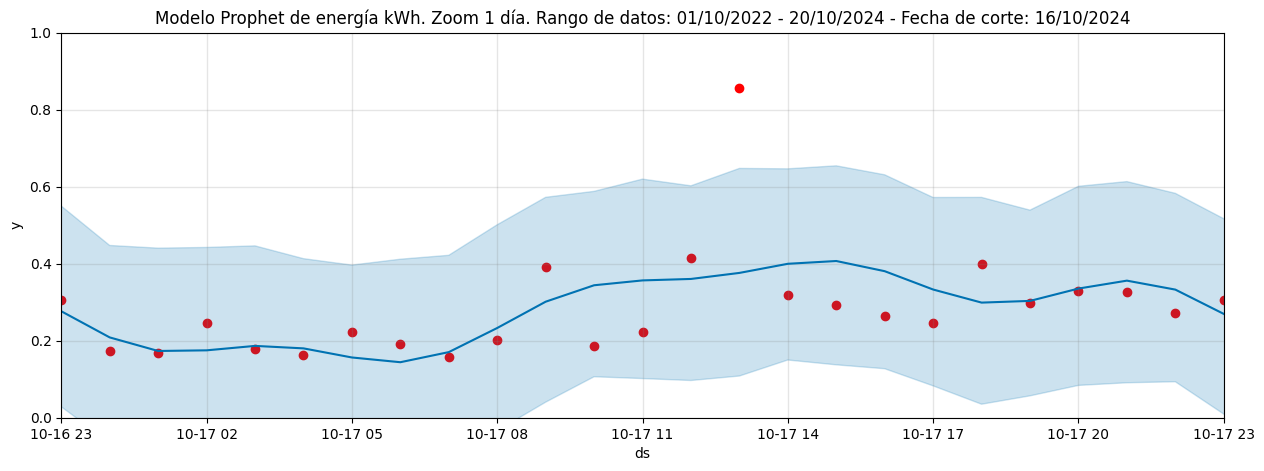

In [483]:
# Establecer el rango de visualización desde split_date hasta split_date + 24h
range_start = pd.to_datetime(split_date)
range_end = range_start + pd.DateOffset(days=1)

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model.plot(test_forecast, ax=ax)
ax.set_title(f'Modelo Prophet de energía kWh. Zoom 1 día. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} - Fecha de corte: {split_date.strftime("%d/%m/%Y")}')
ax.set_xbound(lower=range_start, upper=range_end)
ax.set_ybound(lower=0, upper=1)
plt.show()

## Evaluar el modelo con métricas de error

In [484]:
# Mostrar las fechas con las que se ha trabajado
print(f"Fecha de inicio: {start_date.strftime('%d/%m/%Y')}")
print(f"Fecha de fin: {end_date.strftime('%d/%m/%Y')}")
print(f"Fecha de corte: {split_date.strftime('%d/%m/%Y %H:%M:%S')}")

# Caracterizar los datos de energía consumida en el rango de fechas completo 
print("\nDatos de partida para el rango de fechas seleccionado agrupados por hora:")
print(f"Energía media consumida: {total_data['total_kWh'].mean():.2f} kWh")
print(f"Energía máxima consumida: {total_data['total_kWh'].max():.2f} kWh")
print(f"Energía mínima consumid: {total_data['total_kWh'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {total_data['total_kWh'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {total_data['total_kWh'].std():.2f} kWh")

# Caracterizar los datos de energía consumida en el rango de fechas de prueba. Valores reales
print("\nDatos de partida para el subconjunto de prueba agrupados por hora:")
print(f"Energía media consumida: {test['total_kWh'].mean():.2f} kWh")
print(f"Energía máxima consumida: {test['total_kWh'].max():.2f} kWh")
print(f"Energía mínima consumid: {test['total_kWh'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {test['total_kWh'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {test['total_kWh'].std():.2f} kWh")

# Caracterizar los datos de energía consumida en el rango de fechas de prueba. Valores pronosticados
print("\nDatos pronosticados en el periodo de prueba agrupados por hora:")
print(f"Energía media consumida: {test_forecast['yhat'].mean():.2f} kWh")
print(f"Energía máxima consumida: {test_forecast['yhat'].max():.2f} kWh")
print(f"Energía mínima consumid: {test_forecast['yhat'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {test_forecast['yhat'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {test_forecast['yhat'].std():.2f} kWh")

# Error medio en kWh
me_value= np.sqrt(mean_squared_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat']))
# Error porcentual absoluto medio MAPE
mape_value= mean_absolute_percentage_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat'])
# Error cuadrático medio en kWh
mse_value= mean_squared_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat'])

# Mostrar errores de predicción
print("\nErrores de predicción:")
print(f"Error medio: {me_value:.2f}kWh")
print(f"MAPE: {mape_value:.2f}%")
print(f"Error cuadrático medio: {mse_value:.2f}kWh^2")

Fecha de inicio: 01/10/2022
Fecha de fin: 20/10/2024
Fecha de corte: 16/10/2024 23:00:00

Datos de partida para el rango de fechas seleccionado agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 2.52 kWh
Energía mínima consumid: 0.09 kWh
Varianza de la energía consumida: 0.05 kWh^2
Desviación estándar de la energía consumida: 0.22 kWh

Datos de partida para el subconjunto de prueba agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 1.57 kWh
Energía mínima consumid: 0.15 kWh
Varianza de la energía consumida: 0.03 kWh^2
Desviación estándar de la energía consumida: 0.18 kWh

Datos pronosticados en el periodo de prueba agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 0.42 kWh
Energía mínima consumid: 0.14 kWh
Varianza de la energía consumida: 0.01 kWh^2
Desviación estándar de la energía consumida: 0.09 kWh

Errores de predicción:
Error medio: 0.17kWh
MAPE: 28.97%
Error cuadrático medio: 0.03kWh^2


# Considerar los festivos en la predicción
Vamos a añadir los festivos como indicadores para ver si es posible ayudar a mejorar las predicciones.
Prophet permite pasar el parámetro `holidays` al modelo antes del entrenamiento.

Nuestro objetivo es categorizar las fechas de un año concreto indicando el festivo con nombre que les corresponde para que Prophet pueda buscar correlaciones.
Para ello generaremos un listado de festivos que se puedan asignar a las fechas de nuestros datos de partida.

Para EEUU pandas dispone de una ayuda que permite generar todo esto de forma automática para sus propios festivos, que no guardan casi ninguna relación con los festivos en España.

EEUU: clase USFederalHolidayCalendar en pandas.tseries.holiday

En España usaremos la clase AbstractHolidayCalendar para mediante herencia definir una clase con los festivos de España

Uno de los problemas del calendario de festivos en España reside en el cálculo de la Semana Santa ya que sus fechas cambian de año en año.
Nos apoyaremos en el siguiente algoritmo que permite determinar la fecha del Domingo de Pascua y a partir de él, crearemos funciones que permitan determinar la fecha de Jueves Santo y Viernes Santo.

In [485]:
from datetime import date, timedelta
def get_domingo_pascua(year):
    """
    Calcula la fecha del Domingo de Pascua para un año dado.
    
    Parámetros:
    year (int): El año para el cual se quiere calcular el Domingo de Pascua.
    
    Retorna:
    pd.Timestamp: La fecha del Domingo de Pascua.
    """    
    # Calculate Easter Sunday using the Anonymous Gregorian algorithm
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    month = (h + l - 7 * m + 114) // 31
    day = ((h + l - 7 * m + 114) % 31) + 1

    return date(year, month, day)

def get_jueves_santo(year):
    """Calculate the date of Maundy Thursday for a given year."""
    domingo_pascua = get_domingo_pascua(year)
    jueves_santo = domingo_pascua - timedelta(days=3)
    return pd.Timestamp(jueves_santo)

def get_viernes_santo(year):
    """Calculate the date of Good Friday for a given year."""
    domingo_pascua = get_domingo_pascua(year)
    viernes_santo = domingo_pascua - timedelta(days=2)
    return pd.Timestamp(viernes_santo)


Para crear la clase `class SpainHolidayCalendar(AbstractHolidayCalendar)` vamos a necesitar otra función adicional.
Se observa que las reglas disponibles para `observance` de la clase `AbstractHolidayCalendar`, no encajan con la forma de mover festivos en España. Por ejemplo con `observance=nearest_workday` el Dia de Todos los Santos de 2025 por caer en Sábado lo pasará a Viernes, lo cual no corresponde con la forma de regular en España, donde un domingo pasa a lunes o sábado. Valores predefinidos para `observance`:
`nearest_workday`: Ajusta el día festivo al día laboral más cercano. Si el día festivo cae en sábado, se mueve al viernes anterior. Si cae en domingo, se mueve al lunes siguiente.
`next_monday`: Ajusta el día festivo al siguiente lunes si cae en fin de semana.
`previous_friday`: Ajusta el día festivo al viernes anterior si cae en fin de semana.

El parametro observance recibe una función callback que debe tener como parámetro un datetime y devolver otro datetime sustituto
Para resolver el caso de España definiremos una función de observancia personalizada `mover_domingo`:

In [486]:
def mover_domingo(dt):
    """
    Ajusta el día festivo al lunes siguiente si cae en domingo.
    
    Parámetros:
    dt (pd.Timestamp): La fecha original del día festivo.
    
    Retorna:
    pd.Timestamp: La fecha ajustada al lunes siguiente si cae en domingo, de lo contrario la fecha original.
    """
    if dt.weekday() == 6:  # Domingo
        return dt + pd.Timedelta(days=1)
    else:
        return dt

Con las funciones anteriores, finalmente ya podemos definir la clase de tipo Calendar.

In [487]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday

class SpainHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('Año Nuevo', month=1, day=1, observance=mover_domingo),
        Holiday('Día de Reyes', month=1, day=6),
        Holiday('Jueves Santo', month=1, day=1, observance=lambda x: get_jueves_santo(x.year)),
        Holiday('Viernes Santo', month=1, day=1, observance=lambda x: get_viernes_santo(x.year)),
        Holiday('Día del Trabajador', month=5, day=1, observance=mover_domingo),
        Holiday('Asunción de la Virgen', month=8, day=15),
        Holiday('Día de la Hispanidad', month=10, day=12),
        Holiday('Todos los Santos', month=11, day=1, observance=mover_domingo),
        Holiday('Día de la Constitución', month=12, day=6, observance=mover_domingo),
        Holiday('Inmaculada Concepción', month=12, day=8, observance=mover_domingo),
        Holiday('Navidad', month=12, day=25, observance=mover_domingo)        
    ]

In [488]:
# Convertir los índices a objetos Timestamp
start_date = pd.to_datetime(total_data.index.min())
end_date = pd.to_datetime(total_data.index.max())

# Obtener los días festivos
cal = SpainHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date, return_name=True)
holiday_df=pd.DataFrame(data=holidays, columns=['holiday'])
# Convertir a un formato compatible con Prophet
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
holiday_df.head()

,ds,holiday
0,2022-10-12,Día de la Hispanidad
1,2022-11-01,Todos los Santos
2,2022-12-06,Día de la Constitución
3,2022-12-08,Inmaculada Concepción
4,2022-12-26,Navidad


In [489]:
holiday_df['holiday'].value_counts()

holiday
Día de la Hispanidad      3
Todos los Santos          2
Día de la Constitución    2
Inmaculada Concepción     2
Navidad                   2
Año Nuevo                 2
Día de Reyes              2
Jueves Santo              2
Viernes Santo             2
Día del Trabajador        2
Asunción de la Virgen     2
Name: count, dtype: int64

Ahora podemos crear un nuevo modelo de Prophet esta vez pasando los festivos como parámetros

In [490]:
%%time
model_with_holiday=Prophet(holidays=holiday_df)
model_with_holiday.fit(train_prophet)

17:22:44 - cmdstanpy - INFO - Chain [1] start processing
17:22:48 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 2.33 s
Wall time: 6.46 s


In [491]:
# Predict on test set with model_with_holiday
test_forecast = model_with_holiday.predict(test_prophet)
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Año Nuevo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-10-16 23:00:00,0.308667,0.025753,0.516074,0.308667,0.308667,0.0,0.0,0.0,0.0,...,-0.005736,-0.005736,-0.005736,-0.018835,-0.018835,-0.018835,0.0,0.0,0.0,0.270618
1,2024-10-17 00:00:00,0.308667,-0.045872,0.454328,0.308667,0.308667,0.0,0.0,0.0,0.0,...,-0.006638,-0.006638,-0.006638,-0.018880,-0.018880,-0.018880,0.0,0.0,0.0,0.202721
2,2024-10-17 01:00:00,0.308668,-0.081635,0.413837,0.308668,0.308668,0.0,0.0,0.0,0.0,...,-0.007506,-0.007506,-0.007506,-0.018925,-0.018925,-0.018925,0.0,0.0,0.0,0.167612
3,2024-10-17 02:00:00,0.308669,-0.077879,0.413199,0.308669,0.308669,0.0,0.0,0.0,0.0,...,-0.008332,-0.008332,-0.008332,-0.018970,-0.018970,-0.018970,0.0,0.0,0.0,0.169395
4,2024-10-17 03:00:00,0.308669,-0.070168,0.439508,0.308669,0.308669,0.0,0.0,0.0,0.0,...,-0.009107,-0.009107,-0.009107,-0.019016,-0.019016,-0.019016,0.0,0.0,0.0,0.181042


Ahora en las columnas aparecen los festivos que hemos definido, aunque como se ve, con estos datos no ha encontrando ninguna correlación con los festivos ya que los términos aditivos están todos a cero

In [492]:
test_forecast.loc[test_forecast['ds'].isin(holidays.index)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Año Nuevo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat


In [493]:
test_forecast.loc[0]


ds                              2024-10-16 23:00:00
trend                                      0.308667
yhat_lower                                 0.025753
yhat_upper                                 0.516074
trend_lower                                0.308667
trend_upper                                0.308667
Asunción de la Virgen                           0.0
Asunción de la Virgen_lower                     0.0
Asunción de la Virgen_upper                     0.0
Año Nuevo                                       0.0
Año Nuevo_lower                                 0.0
Año Nuevo_upper                                 0.0
Día de Reyes                                    0.0
Día de Reyes_lower                              0.0
Día de Reyes_upper                              0.0
Día de la Constitución                          0.0
Día de la Constitución_lower                    0.0
Día de la Constitución_upper                    0.0
Día de la Hispanidad                            0.0
Día de la Hi

In [494]:
# Mostrar solo las columnas del indice 0 que tengan valores <> 0
test_forecast.loc[0][test_forecast.loc[0] != 0]

ds                      2024-10-16 23:00:00
trend                              0.308667
yhat_lower                         0.025753
yhat_upper                         0.516074
trend_lower                        0.308667
trend_upper                        0.308667
additive_terms                    -0.038049
additive_terms_lower              -0.038049
additive_terms_upper              -0.038049
daily                             -0.013478
daily_lower                       -0.013478
daily_upper                       -0.013478
weekly                            -0.005736
weekly_lower                      -0.005736
weekly_upper                      -0.005736
yearly                            -0.018835
yearly_lower                      -0.018835
yearly_upper                      -0.018835
yhat                               0.270618
Name: 0, dtype: object

In [495]:

test_forecast[['ds','yhat']].head()

,ds,yhat
0,2024-10-16 23:00:00,0.270618
1,2024-10-17 00:00:00,0.202721
2,2024-10-17 01:00:00,0.167612
3,2024-10-17 02:00:00,0.169395
4,2024-10-17 03:00:00,0.181042


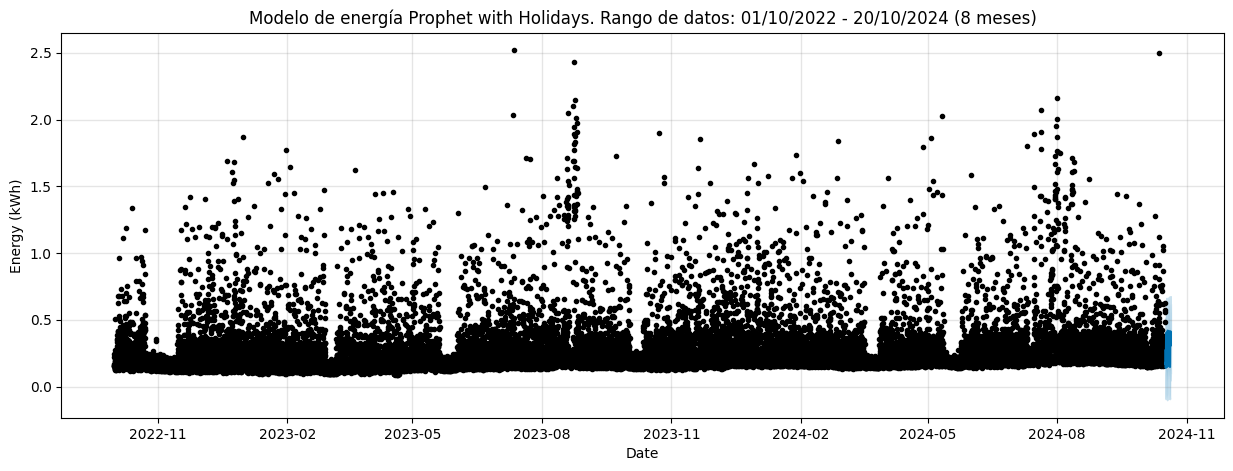

In [496]:

fig, ax = plt.subplots(figsize=(15, 5))
fig = model_with_holiday.plot(test_forecast, xlabel='Date', ylabel='Energy (kWh)', ax=ax)   
ax.set_title(f'Modelo de energía Prophet with Holidays. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.show()

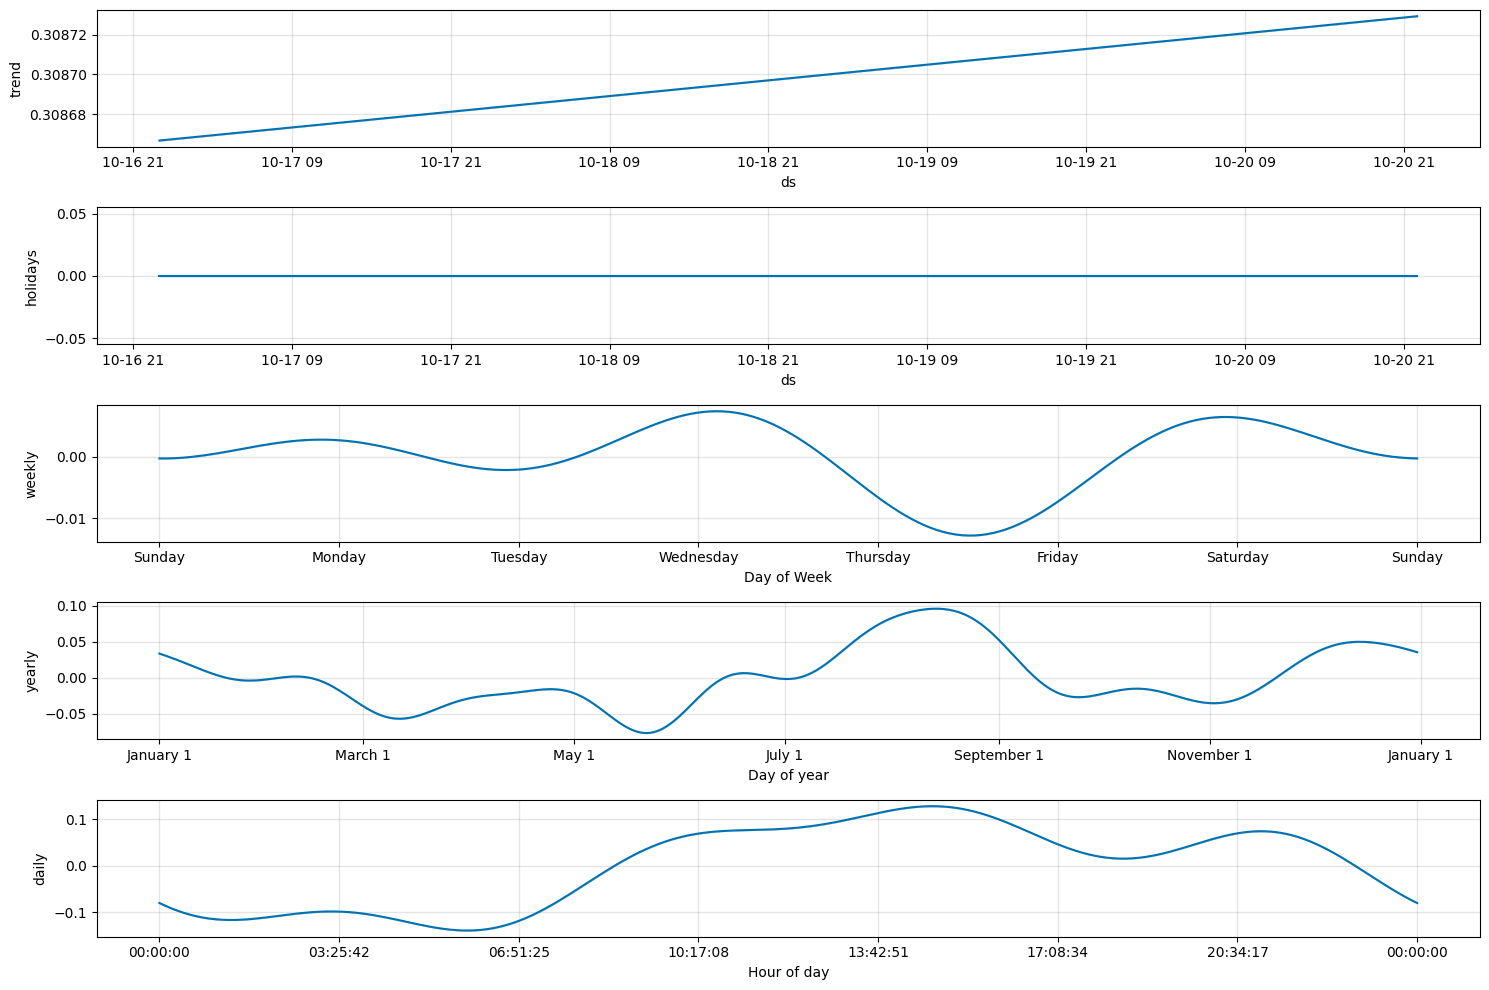

In [497]:

fig = model_with_holiday.plot_components(test_forecast, figsize=(15, 10))
plt.show()

## Comparar la previsión con los datos reales

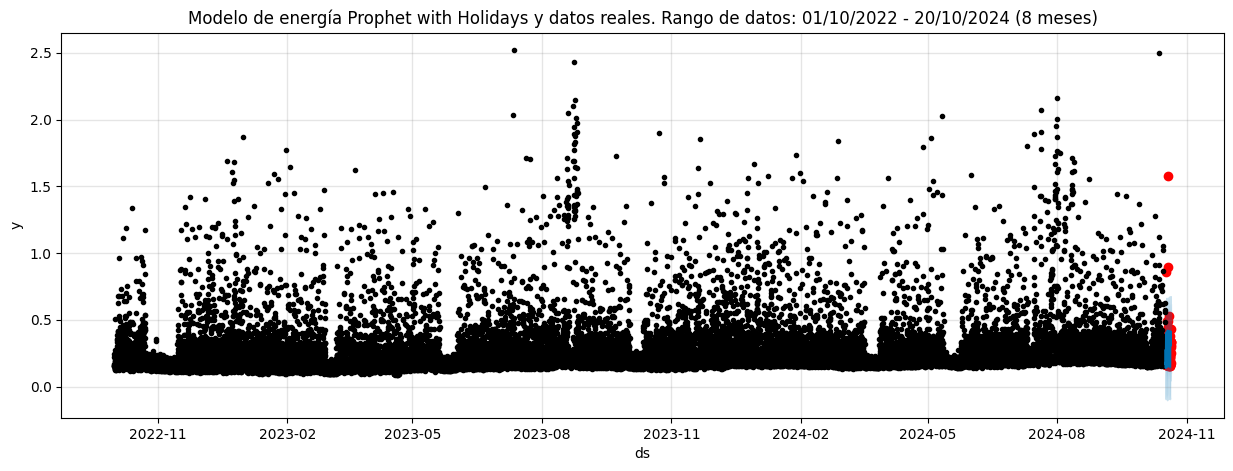

In [498]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model_with_holiday.plot(test_forecast, ax=ax)
ax.set_title(f'Modelo de energía Prophet with Holidays y datos reales. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.show()

## Hacer zoom en la zona de test

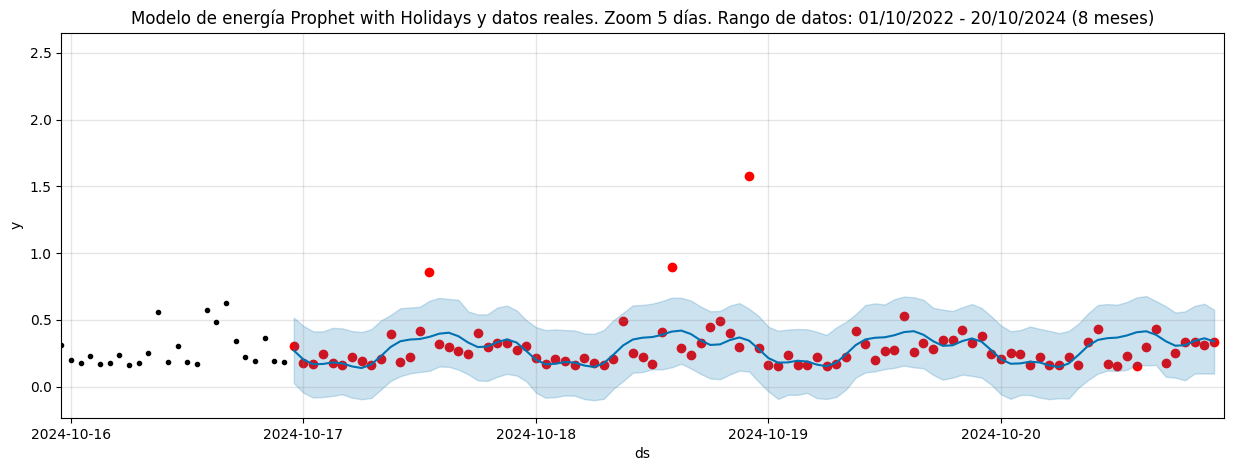

In [499]:
# Plot the forecast with the actuals with zoom
# Establecer el rango de visualización desde split_date-1 hasta split_date + 15 días
range_start = pd.to_datetime(split_date) - pd.DateOffset(days=1)
range_end = range_start + pd.DateOffset(days=5)

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model_with_holiday.plot(test_forecast, ax=ax)
ax.set_xbound(lower=range_start, upper=range_end)
ax.set_title(f'Modelo de energía Prophet with Holidays y datos reales. Zoom 5 días. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.show()

## Inspeccionar los datos por horas del primer día de la predicción

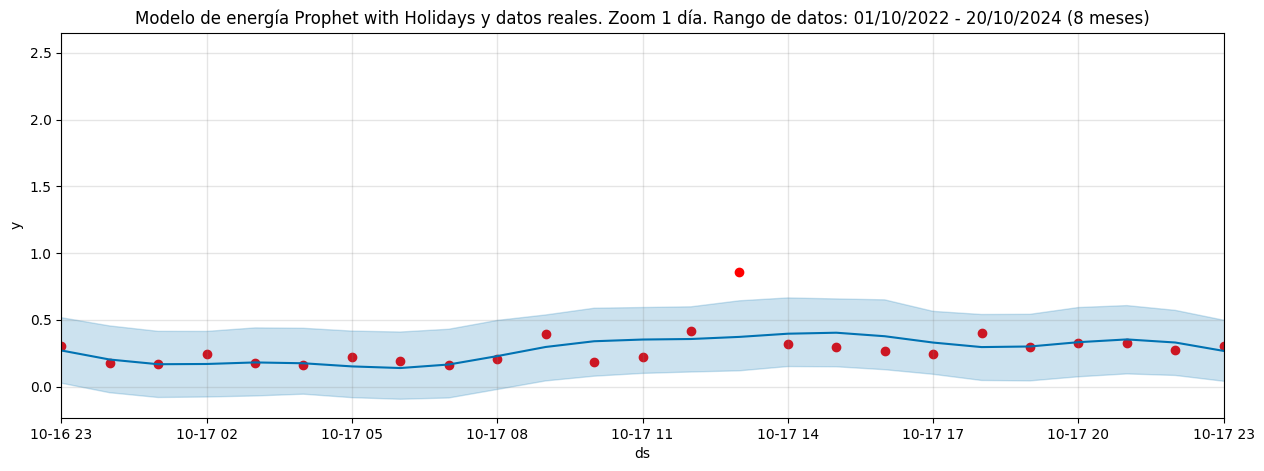

In [500]:
# Establecer el rango de visualización desde split_date hasta split_date + 24h
range_start = pd.to_datetime(split_date)
range_end = range_start + pd.DateOffset(days=1)

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['total_kWh'], color='r')
fig = model_with_holiday.plot(test_forecast, ax=ax)
ax.set_xbound(lower=range_start, upper=range_end)
ax.set_title(f'Modelo de energía Prophet with Holidays y datos reales. Zoom 1 día. Rango de datos: {start_date.strftime("%d/%m/%Y")} - {end_date.strftime("%d/%m/%Y")} ({meses} meses)')
plt.show()

## Evaluar el modelo con métricas de error

In [501]:
# Mostrar las fechas con las que se ha trabajado
print(f"Fecha de inicio: {start_date.strftime('%d/%m/%Y')}")
print(f"Fecha de fin: {end_date.strftime('%d/%m/%Y')}")
print(f"Fecha de corte: {split_date.strftime('%d/%m/%Y %H:%M:%S')}")

# Caracterizar los datos de energía consumida en el rango de fechas completo 
print("\nDatos de partida para el rango de fechas seleccionado agrupados por hora:")
print(f"Energía media consumida: {total_data['total_kWh'].mean():.2f} kWh")
print(f"Energía máxima consumida: {total_data['total_kWh'].max():.2f} kWh")
print(f"Energía mínima consumid: {total_data['total_kWh'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {total_data['total_kWh'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {total_data['total_kWh'].std():.2f} kWh")

# Caracterizar los datos de energía consumida en el rango de fechas de prueba. Valores reales
print("\nDatos de partida para el subconjunto de prueba agrupados por hora:")
print(f"Energía media consumida: {test['total_kWh'].mean():.2f} kWh")
print(f"Energía máxima consumida: {test['total_kWh'].max():.2f} kWh")
print(f"Energía mínima consumid: {test['total_kWh'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {test['total_kWh'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {test['total_kWh'].std():.2f} kWh")

# Caracterizar los datos de energía consumida en el rango de fechas de prueba. Valores pronosticados
print("\nDatos pronosticados en el periodo de prueba agrupados por hora:")
print(f"Energía media consumida: {test_forecast['yhat'].mean():.2f} kWh")
print(f"Energía máxima consumida: {test_forecast['yhat'].max():.2f} kWh")
print(f"Energía mínima consumid: {test_forecast['yhat'].min():.2f} kWh")
print(f"Varianza de la energía consumida: {test_forecast['yhat'].var():.2f} kWh^2")
print(f"Desviación estándar de la energía consumida: {test_forecast['yhat'].std():.2f} kWh")

# Error medio en kWh
me_value= np.sqrt(mean_squared_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat']))
# Error porcentual absoluto medio MAPE
mape_value= mean_absolute_percentage_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat'])
# Error cuadrático medio en kWh
mse_value= mean_squared_error(y_true=test['total_kWh'], y_pred=test_forecast['yhat'])

# Mostrar errores de predicción
print("\nErrores de predicción:")
print(f"Error medio: {me_value:.2f}kWh")
print(f"MAPE: {mape_value:.2f}%")
print(f"Error cuadrático medio: {mse_value:.2f}kWh^2")

Fecha de inicio: 01/10/2022
Fecha de fin: 20/10/2024
Fecha de corte: 16/10/2024 23:00:00

Datos de partida para el rango de fechas seleccionado agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 2.52 kWh
Energía mínima consumid: 0.09 kWh
Varianza de la energía consumida: 0.05 kWh^2
Desviación estándar de la energía consumida: 0.22 kWh

Datos de partida para el subconjunto de prueba agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 1.57 kWh
Energía mínima consumid: 0.15 kWh
Varianza de la energía consumida: 0.03 kWh^2
Desviación estándar de la energía consumida: 0.18 kWh

Datos pronosticados en el periodo de prueba agrupados por hora:
Energía media consumida: 0.29 kWh
Energía máxima consumida: 0.42 kWh
Energía mínima consumid: 0.14 kWh
Varianza de la energía consumida: 0.01 kWh^2
Desviación estándar de la energía consumida: 0.09 kWh

Errores de predicción:
Error medio: 0.17kWh
MAPE: 28.59%
Error cuadrático medio: 0.03kWh^2


Se obtiene un MAPE del 28%, valor idéntico al obtenido cuando no se han tenido en cuenta los festivos.